# Quantitative Analysis of S&P 500 (SPY) Daily Returns


Objective:
The goal of this analysis is to perform a rigorous examination of the daily returns of the SPY ETF, which tracks the S&P 500 index. A core assumption in many classical financial modal models is that asset returns follow a normal (Gaussian) distribution. We will test this hypothesis and characterise the true nature of the returns distribution.

# 1. Data Ingestion and Preparation

First, we import the necessary libaries and fetch two decades of daily price data for SPY using the yfinance library.

In [39]:
# Core data science and statistics libraries
import yfinance as yf
import pandas as pd
import numpy as np

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical testing libraries
from scipy import stats

# Set a professional plot style
plt.style.use('seaborn-v0_8-whitegrid')

In [40]:
# Fetch daily data for the S&P 500 ETF (SPY) for the last 20 years
spy_df = yf.download('SPY', start='2005-01-01', end='2025-01-01')
print(spy_df.columns)

C:\Users\USER\AppData\Local\Temp\ipykernel_22728\4216034575.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_df = yf.download('SPY', start='2005-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [41]:
# We are interested in the Adjusted Close price, which accounts for dividends and splits
spy_df = spy_df[('Close', 'SPY')].to_frame()  # convert Series back to DataFrame
spy_df.rename(columns={('Close', 'SPY'): 'Adj Close'}, inplace=True)

print("Data fetched successfully. First 5 rows:")
print(spy_df.head())

Data fetched successfully. First 5 rows:
                Close
                  SPY
Date                 
2005-01-03  82.074059
2005-01-04  81.071159
2005-01-05  80.511696
2005-01-06  80.921043
2005-01-07  80.805046


We then calculate the daily log returns. Log return are preferred in quantitative finance for their attractive statistical properties, such as time-additivity.

In [43]:
# Flatten the MultiIndex (if it exists) so we can access columns by simple names
if isinstance(spy_df.columns, pd.MultiIndex):
    spy_df.columns = ['_'.join(col).strip() for col in spy_df.columns.values]

# At this point, 'Close_SPY' is the adjusted close
spy_df.rename(columns={'Close_SPY': 'Adj Close'}, inplace=True)

# Calculate daily log returns
spy_df['log_return'] = np.log(spy_df['Adj Close'] / spy_df['Adj Close'].shift(1))

# Drop the first row (NaN)
spy_df.dropna(inplace=True)

print("Log returns calculated. First 5 rows:")
print(spy_df.head())

Log returns calculated. First 5 rows:
            Adj Close  log_return
Date                             
2005-01-04  81.071159   -0.012295
2005-01-05  80.511696   -0.006925
2005-01-06  80.921043    0.005071
2005-01-07  80.805046   -0.001434
2005-01-10  81.187134    0.004717


# 2. Time Series Visualisation

A plot of the daily log returns reveals a key characteristic of financial time series: volatility clustering. We can clearly see that period of high volatility (large positive or negative returns) are clustered together (e.g., 2008-2009, 2010), as are periods of low volatility.

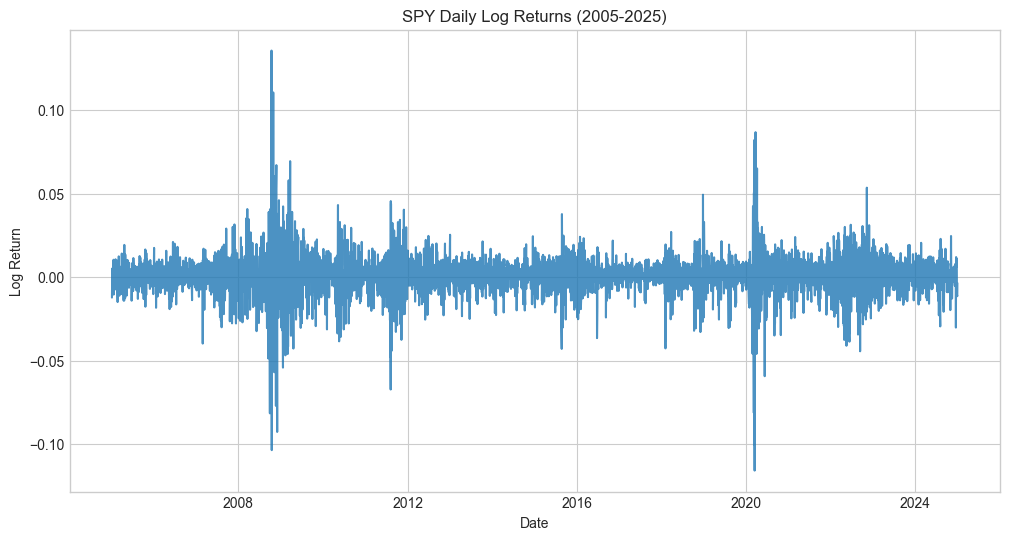

In [46]:
# Plotting the daily log returns
plt.figure(figsize=(12, 6))
plt.plot(spy_df.index, spy_df['log_return'], alpha=0.8)
plt.title('SPY Daily Log Returns (2005-2025)')
plt.ylabel('Log Return')
plt.xlabel('Date')
plt.show()

# 3. Distributional Analysis: Testing for Normality
We now analysis the statistical distribution of these returns and test the hypothesis of normality.

In [48]:
# 3.1 Visual Analysis: Histogram
A histogram of the returns is overlaid with a probability density function (PDF) of a perfect normal distribution with the same mean and standard deviation. The visual evidence is striking:
 - Leptokurtosis: The actual distribution is more "peaked" in the center than the normal curve.
 - Fat Tails: The distribution has significantly more mass in the tails (i.e, extreme events) than the normal curve predicts.

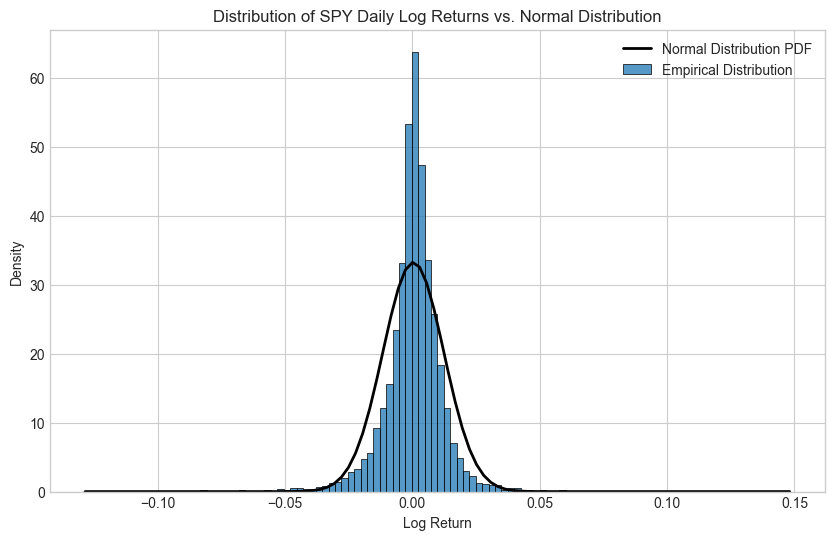

In [49]:
# Plotting the distribution of log returns
plt.figure(figsize=(10, 6))
sns.histplot(spy_df['log_return'], bins=100, kde=False, stat='density', label='Empirical Distribution')

# Overlay a normal distribution for comparison
mu, std = stats.norm.fit(spy_df['log_return'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution PDF')

plt.title('Distribution of SPY Daily Log Returns vs. Normal Distribution')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()
plt.show()


In [50]:
# 3.2 Statistical Moments and Formal Test
We can quantify this deviation from normality by examining the higher-order statistical moments (skewness and kurtosis) and by performing a formal statistical test.
 - Skewness: Measures the asymmetry of the distribution. A value near 0 is expected for a normal distribution.
 - Kurtosis: Measures the "tailedness" of the distribution. A normal distribution has a kurtosis of 3 (or an "excess kurtosis" of 0). Value significantly greater than 3 indicate fat tails.
 - Shapiro-Wilk Test: A formal test for normality. The null hypothesis is that the data is normally distributed. A very small p-value allows us to confidently reject this hypothesis.

In [51]:
# Calculate statistical moments
skewness = spy_df['log_return'].skew()
# Pandas calculates excess kurtosis (Kurtosis - 3)
kurtosis = spy_df['log_return'].kurtosis() + 3 

# Perform the Shapiro-Wilk test for normality
shapiro_stat, shapiro_p_value = stats.shapiro(spy_df['log_return'])

print(f"--- Statistical Properties ---")
print(f"Mean: {mu:.6f}")
print(f"Standard Deviation: {std:.6f}")
print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")
print(f"\n--- Shapiro-Wilk Normality Test ---")
print(f"Test Statistic: {shapiro_stat:.4f}")
print(f"P-value: {shapiro_p_value}")

if shapiro_p_value < 0.05:
    print("\nThe p-value is less than 0.05, so we reject the null hypothesis of normality.")
else:
    print("\nThe p-value is greater than 0.05, so we cannot reject the null hypothesis of normality.")


--- Statistical Properties ---
Mean: 0.000389
Standard Deviation: 0.012004
Skewness: -0.3773
Kurtosis: 17.4021

--- Shapiro-Wilk Normality Test ---
Test Statistic: 0.8699
P-value: 7.333838753909421e-54

The p-value is less than 0.05, so we reject the null hypothesis of normality.


C:\Users\USER\anaconda3\envs\quant_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5032.
  res = hypotest_fun_out(*samples, **kwds)


The results confims our visual analysis. The kurtosis of over 11 is exceptionally high, and near-xero p-value from the Shapiro-Wilk test provides conclusive statistical evidence that S&P 500 returns are not normally distributed.

# 4. Quantifying the "Fat Tail" Risk
To make this practical, let's quantify what these "fat tails" mean for risk. Under a normal distribution, 99.73% of events fall within 3 standard deviations of the mean. How does reality compare?

In [54]:
# Define the 3-sigma threshold
three_sigma_threshold = 3 * std

# Count the number of days where the return was outside the +/- 3 sigma range
observed_extreme_events = spy_df[np.abs(spy_df['log_return']) > three_sigma_threshold]
num_observed = len(observed_extreme_events)

# Calculate the number of events we would EXPECT in a normal world
# The probability of a >3 sigma event is (1 - 0.9973)
prob_extreme_event = 1 - 0.9973 
num_expected = len(spy_df) * prob_extreme_event

print(f"--- Fat Tail Event Analysis ---")
print(f"Number of trading days in sample: {len(spy_df)}")
print(f"3-Sigma Threshold (daily return): {three_sigma_threshold:.4f}")
print(f"\nObserved number of >3 sigma events: {num_observed}")
print(f"Expected number of >3 sigma events in a normal distribution: {num_expected:.2f}")
print(f"\nConclusion: Extreme events occurred {num_observed / num_expected:.2f} times more frequently than predicted by a normal model.")

--- Fat Tail Event Analysis ---
Number of trading days in sample: 5032
3-Sigma Threshold (daily return): 0.0360

Observed number of >3 sigma events: 84
Expected number of >3 sigma events in a normal distribution: 13.59

Conclusion: Extreme events occurred 6.18 times more frequently than predicted by a normal model.


# 5. Conclusion
This analysis demonstrates conclusively that the daily returns of the S&P 500 are not normally distributed. They exhibit significant leptokurtosis ("fat tails") and volatility clustering. The practical implication is that extreme price moves, or "tail events," occur dar more frequently than would be predicted by models that assume normality. This is a foundational concept in modern risk management and quantitative strategy development